# Eksempel på multivariat data: FIFA-skillz
I dette eksempelet tar jeg for meg et datasett bestående av informasjon om alle spillere på FIFA 20, hentet fra [denne linken](https://www.kaggle.com/stefanoleone992/fifa-20-complete-player-dataset). Antagelsen min er at mange ferdigheter er høyt korrelerte (er man god på langpasninger er man gjerne god på innlegg også, for eksempel), og dermed perfekt å anvende ulike metoder var multivariat analyse på.

## Datasett
Datasettet består av litt over 18 000 rader, der hver rad inneholder egenskapene til en fotballspiller. Hver kolonne svarer til en bestemt ferdighet. Etter å ha gjort et utvalg av hvilke ferdigheter (kolonner) som er relevante å analysere, sitter vi igjen med et datasett i form av en matrise $X$ som skriker etter å bli analysert.

## Avhengigheter og forberedende kode
Først importerer vi alle bibliotek vi trenger, forbereder plott, og definerer datasettet vårt. Her fjerner vi alle keepere fordi disse ikke har definert alle ferdigheter vi er interesserte i. Jeg forsøker også å fjerne alle kolonner som inneholder ikke-numeriske verdier, og numeriske verdier som ikke er av typen vi ønsker å undersøke (f.eks. inntekt og markedsveri). Disse har veldig store verdier, og forstyrrer datasettet veldig.

In [83]:
%reset

Nothing done.


In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA

In [85]:
# Lag penere, mer høyoppløselige plott enn seaborn gjør med default-innstillinger
%config InlineBackend.figure_format = 'svg'
sns.set_context("notebook")
sns.set(style="ticks", font="Latin Modern Math")

In [86]:
datapath = "../datasett/fifa-20-complete-player-dataset/players_20.csv"
all_player_data = pd.read_csv(datapath)
all_player_data.sort_values('overall');
player_data_without_gk = all_player_data[all_player_data.loc[:, 'player_positions'] != 'GK']
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
player_data = player_data_without_gk.select_dtypes(include=numeric_dtypes)
player_data = player_data.drop(['sofifa_id', 'wage_eur', 'value_eur'], axis='columns')
player_data = player_data.dropna(axis='columns')

## Variabler
Vi er interesserte i å forklare totale ferdigheter, ``overall``, som funksjon av alle andre variabler. Disse blir da hhv. $y$ og $X$. Både ``overall``, og ``potential`` droppes fra $X$, siden disse henger så tett sammen. Jeg splitter datasettet opp i et test- og et treningssett, half ´n half. I tillegg må jeg gjøre litt kjedelige, praktiske ting, som å sentrere og normalisere alle datasettene.

In [87]:
player_data_train, player_data_test = train_test_split(player_data, test_size=0.2, random_state=420)
y_data = player_data_train.loc[:, 'overall']
y_test_data = player_data_test.loc[:, 'overall']
X_data = player_data_train.drop(['overall', 'potential'], axis='columns')
X_test_data = player_data_test.drop(['overall', 'potential'], axis='columns')

y = y_data.to_numpy()
y_test = y_test_data.to_numpy()
X = X_data.to_numpy()
X_test = X_test_data.to_numpy()

n = len(y)
n_test = len(y_test)

In [88]:
mlr_fit = LinearRegression().fit(X, y)
y_hat = mlr_fit.predict(X)
y_hat_test = mlr_fit.predict(X_test)
mlr_mse_train = sum((y_hat - y)**2)/n
mlr_mse_test = sum((y_hat_test - y_test)**2)/n_test
print(f"MSE for prediksjoner på treningssett: {mlr_mse_train:.2f}")
print(f"MSE for prediksjoner på testsett: {mlr_mse_test:.2f}")

MSE for prediksjoner på treningssett: 5.16
MSE for prediksjoner på testsett: 5.27


Litt (men ikke særlig) avhengig av hvordan man deler opp i test- og treningssett ser vi at MSE for prediksjonene til denne estimatoren ligger på ca. $4,6$ for treningssett, og $4,8$ for testsett. Med størrelsen på datasettet er det naturlig å la dette være et slags mål på hvor godt det er mulig å tilpasse en linær modell, siden LS eksplisitt minimerer MSE for et gitt datasett. Det er interessant å se at forventet avvik er såpass stort, dette tyder på at måten EA bestemmer ``overall``-score på ikke er helt rett fram.

Modellen over tar imidlertid utgangspunkt i en ganske uhåndterlig mengde variabler. Kanskje dataen kan si oss noe om hvilke variabler som best forklarer ``overall``? I så fall burde LS med $\ell_1$-regularisering (LASSO) gi sammenlignbare resultater på testsettet som ren LS. Vi prøver.

Text(0, 0.5, 'MSE på testsett')

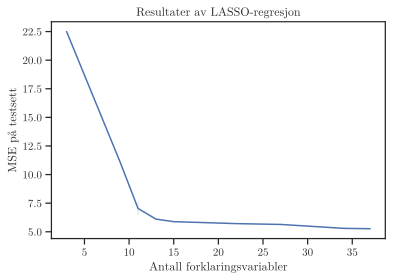

In [89]:
alpha = [2**x for x in range(-5, 6)]
n_alpha = len(alpha)
mlr_mse_train = [0] * n_alpha
mlr_mse_test = [0] * n_alpha
n_model_params = [0] * n_alpha
lasso_fits = [0] * n_alpha
for i in range(0, n_alpha):
    lasso_fit = Lasso(alpha=alpha[i]).fit(X, y)
    y_hat = lasso_fit.predict(X)
    y_hat_test = lasso_fit.predict(X_test)
    mlr_mse_train[i] = sum((y_hat - y)**2)/n
    mlr_mse_test[i] = sum((y_hat_test - y_test)**2)/n_test
    n_model_params[i] = lasso_fit.sparse_coef_.count_nonzero()
    lasso_fits[i] = lasso_fit
plt.close()
plt.figure(figsize=(6,4))
sns.lineplot(x=n_model_params, y=mlr_mse_test)
plt.title('Resultater av LASSO-regresjon')
plt.xlabel('Antall forklaringsvariabler')
plt.ylabel('MSE på testsett')

Vi ser tydelig at det er forholdsvis lite å hente på å benytte stort mer enn 13 av variablene (som tilsvarer $\lambda = 2$) for å forklare ``overall``-skillz. Men hvilke ferdigheter er det egentlig som er viktigst?

In [90]:
important_skill_indices = np.nonzero(lasso_fits[6].coef_)
print(X_data.columns.values[important_skill_indices])

['attacking_crossing' 'attacking_heading_accuracy'
 'attacking_short_passing' 'skill_ball_control' 'movement_acceleration'
 'movement_sprint_speed' 'movement_reactions' 'power_shot_power'
 'power_stamina' 'power_strength' 'mentality_composure'
 'defending_marking' 'defending_standing_tackle']


## PCA

Vår streben etter tolkbarhet stopper imidlertid ikke her. La oss bare se på ferdighetene som defineres som nøkkelferdigheter for en spiller, for de 100 beste spillerne i verden.

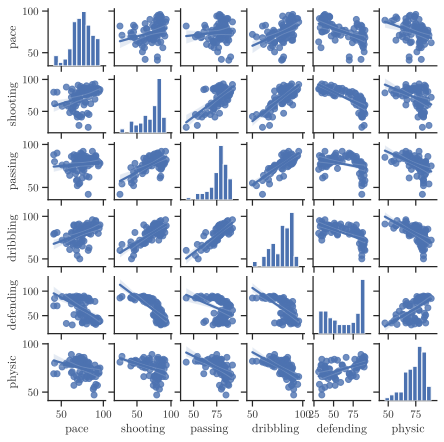

In [91]:
top_player_data = all_player_data.iloc[0:99, :]
key_skills = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']
sns.pairplot(top_player_data.loc[:, key_skills], height=1, aspect=1, kind='reg')

Det er tydelig at selv blant ferdighetene som sees på som aller viktigst, er det store korrelasjoner. Derfor er det ikke unaturlig å tro mange variabler beskriver samme type ferdigheter. PCA er det perfekte redskap for å komme til bunns i dette. For å varme opp kan vi jo kjøre litt PCA kun for disse ferdighetene vi allerede har plottet.

In [107]:
key_player_data = player_data_train.loc[:, key_skills]
key_player_data_std = (key_player_data-key_player_data.mean(axis=0))/key_player_data.std(axis=0,ddof=1)

In [108]:
pca_key_player_data = PCA()
pca_key_player_data.fit(key_player_data_std)
P=pca_key_player_data.components_
T = key_player_data_std.dot(P.T)

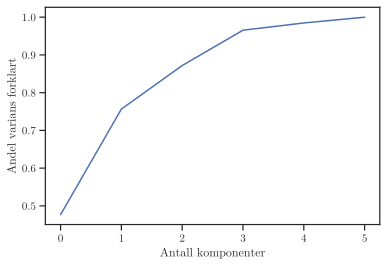

In [109]:
plt.plot(np.cumsum(pca_key_player_data.explained_variance_ratio_))
plt.xlabel('Antall komponenter')
plt.ylabel('Andel varians forklart');

Som vi kan se vil tre PC-er beskrive bortimot 95% av variansen i nøkkelferdigheter. Sammenhengen disse komponentene har med hver opprinnelige ferdighet kan visualiserers i et score-plott.

In [130]:
import re
def find_player_position(pos):
    defender = re.match('.*B', pos)
    midfielder = re.match('.*M|.*W', pos)
    striker = re.match('ST|.*F|.*S', pos)
    if defender:
        return 'Forsvarsspiller'
    elif midfielder:
        return 'Midtbanespiller'
    elif striker:
        return 'Angrepsspiller'
    else:
        return 'ERROR'

In [160]:
#TODO: Ikke kast bort potensiell klassifiseringsdata når du deler opp i trening- og testsett. Da får du ikke plottet kategorisk data i score-plott, blant annet.
n_players = 70
t1 = T.iloc[0:n_players-1, 0]
t2 = T.iloc[0:n_players-1, 1]
#player_pos = player_data.loc[0:n_players-1, 'team_position']
#player_positions = [find_player_position(x) for x in player_pos]

#plt.close()
#plt.figure(figsize=(6,4))
#sns.scatterplot(x=t1, y=t2, hue=player_positions, palette=["#03719c", "#789b73", "#f10c45"])
#plt.title('PC1-PC2 score-plott')
#plt.xlabel('Offensive fibre i kroppen')
#plt.ylabel('Defensive fibre i kroppen')